=== Statistiques de l'analyse de changement d'eau ===
Surface d'eau WorldView : 26761.40 m²
Surface d'eau Drone : 33074.04 m²
Changement net de surface d'eau : 6312.64 m²
Pourcentage de changement par rapport à WorldView : 23.59%


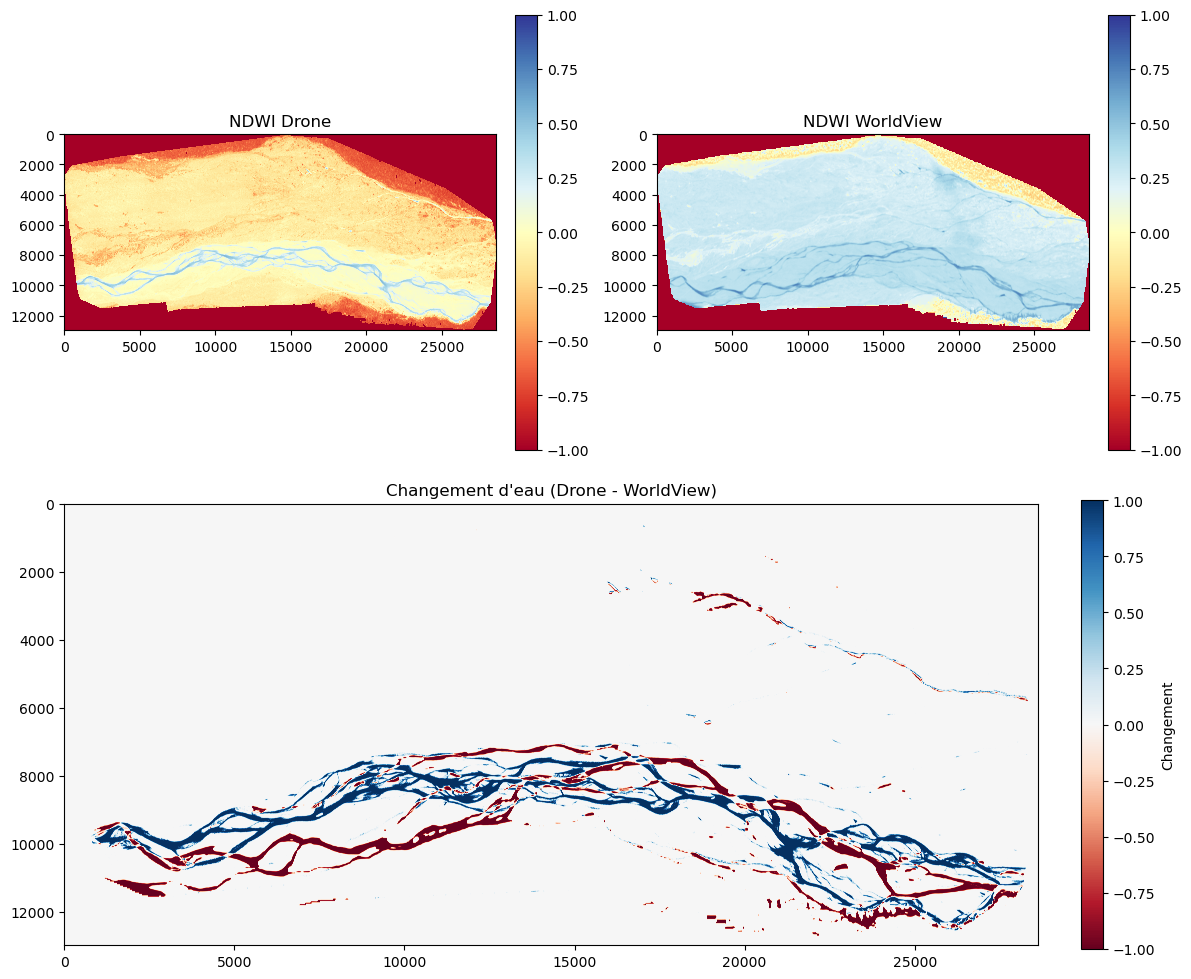

In [5]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

def create_water_mask(ndwi, threshold):
    return (ndwi > threshold).astype(np.uint8)

def analyze_water_change(drone_mask, wv_mask):
    return drone_mask.astype(int) - wv_mask.astype(int)

def main():
    # Chemins des fichiers NDWI
    drone_ndwi_path = r"D:\UQTR\Automne 2024\Ouest\riviere\mavic_ndwi.tif"
    wv_ndwi_path = r"D:\UQTR\Automne 2024\Ouest\riviere\worldview_2_ndwi.tif"

    # Lecture du raster NDWI du drone
    with rasterio.open(drone_ndwi_path) as src:
        drone_ndwi = src.read(1).astype(np.float32)
        drone_crs = src.crs
        drone_transform = src.transform
        drone_width = src.width
        drone_height = src.height
        profile = src.profile

    # Lecture du raster NDWI WorldView
    with rasterio.open(wv_ndwi_path) as src:
        wv_ndwi = src.read(1).astype(np.float32)
        wv_crs = src.crs
        wv_transform = src.transform

    # Reprojection et rééchantillonnage du raster NDWI WorldView
    wv_ndwi_reprojected = np.empty((drone_height, drone_width), dtype=np.float32)

    reproject(
        source=wv_ndwi,
        destination=wv_ndwi_reprojected,
        src_transform=wv_transform,
        src_crs=wv_crs,
        dst_transform=drone_transform,
        dst_crs=drone_crs,
        resampling=Resampling.bilinear
    )

    wv_ndwi = wv_ndwi_reprojected

    # Nettoyer les données
    drone_ndwi = np.nan_to_num(drone_ndwi, nan=0.0, posinf=0.0, neginf=0.0)
    wv_ndwi = np.nan_to_num(wv_ndwi, nan=0.0, posinf=0.0, neginf=0.0)

    # Création des masques d'eau
    drone_threshold = 0.18  # Ajuster selon vos données
    wv_threshold = 0.45     # Ajuster selon vos données
    drone_water_mask = create_water_mask(drone_ndwi, drone_threshold)
    wv_water_mask = create_water_mask(wv_ndwi, wv_threshold)

    # Analyse de changement
    water_change = analyze_water_change(drone_water_mask, wv_water_mask)

    # Sauvegarde des résultats
    profile.update(dtype=rasterio.uint8, count=1, nodata=255)
    with rasterio.open('drone_water_mask.tif', 'w', **profile) as dst:
        dst.write(drone_water_mask, 1)
    with rasterio.open('wv_water_mask.tif', 'w', **profile) as dst:
        dst.write(wv_water_mask, 1)

    profile.update(dtype=rasterio.int8, nodata=-128)
    with rasterio.open('water_change.tif', 'w', **profile) as dst:
        dst.write(water_change, 1)

    # Calcul des statistiques
    pixel_area = abs(drone_transform.a * drone_transform.e)

    drone_water_pixels = np.sum(drone_water_mask == 1)
    wv_water_pixels = np.sum(wv_water_mask == 1)

    drone_water_area = drone_water_pixels * pixel_area
    wv_water_area = wv_water_pixels * pixel_area

    net_water_change_area = drone_water_area - wv_water_area
    percentage_change = (net_water_change_area / wv_water_area) * 100 if wv_water_area != 0 else 0

    # Affichage des statistiques
    print("=== Statistiques de l'analyse de changement d'eau ===")
    print(f"Surface d'eau WorldView : {wv_water_area:.2f} m²")
    print(f"Surface d'eau Drone : {drone_water_area:.2f} m²")
    print(f"Changement net de surface d'eau : {net_water_change_area:.2f} m²")
    print(f"Pourcentage de changement par rapport à WorldView : {percentage_change:.2f}%")

    # Visualisation
    fig = plt.figure(figsize=(12, 10))

    # Masquer les valeurs invalides
    drone_ndwi_masked = ma.masked_invalid(drone_ndwi)
    wv_ndwi_masked = ma.masked_invalid(wv_ndwi)
    water_change_masked = ma.masked_invalid(water_change)

    # Carte NDWI du drone
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    im1 = ax1.imshow(drone_ndwi_masked, cmap='RdYlBu', vmin=-1, vmax=1)
    ax1.set_title('NDWI Drone')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # Carte NDWI WorldView
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    im2 = ax2.imshow(wv_ndwi_masked, cmap='RdYlBu', vmin=-1, vmax=1)
    ax2.set_title('NDWI WorldView')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Carte de changement d'eau
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    im3 = ax3.imshow(water_change_masked, cmap='RdBu', vmin=-1, vmax=1)
    ax3.set_title('Changement d\'eau (Drone - WorldView)')
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, label='Changement')

    plt.tight_layout()
    plt.savefig('water_change_layout.png')
    plt.show()

if __name__ == "__main__":
    main()
